# Creating a Kaggle Workflow

In this project, we're going to create a **data science workflow**.

Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as we expect can be caused by a number of factors along two dimensions:

+ Bugs in implementation
+ Algorithm design

Machine learning problems, have many more dimensions:

+ Bugs in implementation
+ Algorithm design
+ Model issues
+ Data quality

The result of this is that there are exponentially more places that machine can go wrong.

![](https://s3.amazonaws.com/dq-content/188/why-is-ml-hard.png)

This concept is shown in the diagram above (taken from the excellent post [Why is machine learning 'hard'?](http://ai.stanford.edu/~zayd/why-is-machine-learning-hard.html)). The green dot is a 'correct' solution, where the red dots are incorrect solutions. In this illustration there are only a small number of incorrect combinations for software engineering, but in machine learning this becomes exponentially greater!

By defining a workflow for ourself, we can give ourself a framework with which to make iterating on ideas quicker and easier, allowing ourself to work more efficiently.

In this project, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

To get started, we'll read in the original `train.csv` and `test.csv` files from Kaggle.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the Data

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def features_engineering(df):
    
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    
    for col in columns:
        
        df = create_dummies(df, col)
        
    return df

train = features_engineering(train)
holdout = features_engineering(holdout)

## Exploring the Data

The Kaggle workflow is the following:

![](https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg)

+ **Data exploration**, to find patterns in the data
+ **Feature engineering**, to create new features from those patterns or through pure experimentation
+ **Feature selection**, to select the best subset of our current set of features
+ **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: `SibSp` and `Parch`.

In [4]:
train['SibSp'].value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [5]:
train['Parch'].value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

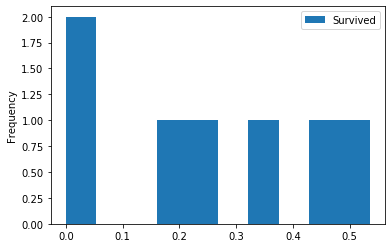

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

sib_pivot = train.pivot_table(index='SibSp', values='Survived')
sib_pivot.plot.hist()

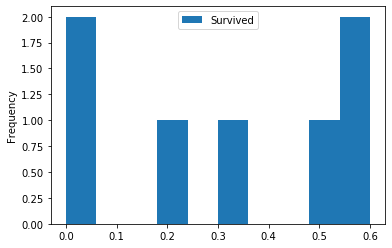

In [7]:
parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.hist()

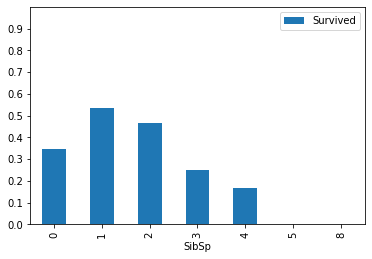

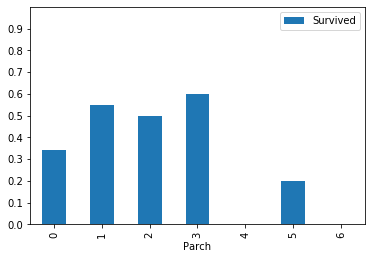

In [8]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()


for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

## Engineering New Features

We have discovered in the previous step that by combining the values of `SibSp` and `Parch` into a single column, only 30% of the passengers who had no family members onboard survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

+ `1` if the passenger has zero family members onboard
+ `0` if the passenger has one or more family members onboard

Let's go ahead and create this feature.

In [9]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

## Selecting the Best-Performing Features

The next step in our workflow is feature selection. 

To speed up our Kaggle workflow, we can create a function that performs the scikit-learn's [`feature_selection.RFECV` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

Let's write a function that:

+ Accepts a dataframe as input
+ Performs data preparation for machine learning
+ Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    
    df = df.select_dtypes(['int64', 'float64']).dropna()
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_Y = df['Survived']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_Y)
    best_columns = list(all_X.columns[selector.support_])
    
    return best_columns 

features = select_features(train)
features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'isalone']

## Selecting and Tuning Different Algorithms 

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

+ The name of the particular model
+ An estimator object for the model
+ A dictionary of hyperparameters that we'll use for grid search.

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's [`model_selection.GridSearchCV` class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained `GridSearchCV` objects as well as the results so we can see which was the most accurate.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df, feautures):
    
    all_X = df[features]
    all_Y = df["Survived"]
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    for model in models:
        
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_Y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, features)

LogisticRegression
Best Score: 0.7206242197253434
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
Best Score: 0.6981897627965045
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
Best Score: 0.7374531835205993
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 6}



## Making a Submission to Kaggle

After running our function, we will have three scores from three different models. At this point in the workflow we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We may find that adding a feature to our model doesn't improve the accuracy. In that case we should go back to data exploration and repeat the cycle again.

If we're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [12]:
def save_submission_file(trained_model, columns):
    
    predictions = trained_model.predict(holdout[columns])
    
    submission_df = {
        'PassengerId': holdout['PassengerId'],
        'Survived': predictions
    }
    submission = pd.DataFrame(submission_df)
    submission.to_csv('submission.csv', index=False)
    
save_submission_file(result[2]['best_model'], features)

## Next Steps

In this project, we created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.

![](https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg)

Here are some suggestions of next steps:

+ Continue to explore the data and create new features, following the workflow and using the functions we created.
+ Read more about the titanic and this Kaggle competition to get ideas for new features.
+ Use some different algorithms in the `select_model()` function, like [support vector machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) linear models.
+ Experiment with `RandomizedSearchCV` instead of GridSearchCV to speed up your select_features() function.